# **MICROSACCADE DETECTOR** #

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import time
import tkinter as tk
from tkinter import filedialog
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Reshape, MaxPooling1D, GlobalAveragePooling1D, Flatten
from keras import regularizers
import seaborn as sns; sns.set() # make plots look cleaner

### **1. Create functions needed to preprocess data and apply machine learning algorithm** ###

In [3]:
# -------------------------------------------- import data HERE -------------------------------------------- #
def import_data():
    # ask user for the path of the file he/she wants to analyze
    root = tk.Tk()
    root.withdraw()

    file_path = filedialog.askopenfilename()
    df = pd.read_csv(file_path)
    eyepos = df.to_numpy()
    return eyepos

# -------------------------------------------- delete blinks and stitch data HERE -------------------------------------------- #
def delete_stitch(data):
    # find start and end of blinks
    blinkstart, blinkend = [], []
    if (data[0,2] == 0):
        blinkstart.append(0)
    for i in range(len(data)-1):
        if (data[i,2] != 0 and data[i+1,2] == 0):
            blinkstart.append(i+1)
        if (data[i,2] == 0 and data[i+1,2] != 0):
            blinkend.append(i)
    if (data[-1,2] == 0):
        blinkend.append(len(data[:,2]))
    blinkstart, blinkend = np.asarray(blinkstart), np.asarray(blinkend)
    
    # calculate the difference between start and end of blinks for stitching
    stitchdiffx, stitchdiffy = np.zeros(len(blinkstart)), np.zeros(len(blinkstart))
    for i in range(len(blinkstart)):
        if blinkend[i] != len(data[:,2]):
            stitchdiffx[i] = (data[blinkend[i]+1,0]) - (data[blinkstart[i]-1,0])
            stitchdiffy[i] = (data[blinkend[i]+1,1]) - (data[blinkstart[i]-1,1])
        if blinkend[i] == len(data[:,2]):
            pass

    # intialize lists to form new data with stitching
    newdatax, newdatay, newdatalabel = [], [], []
    # add first block of good data
    newdatax.append(data[0:blinkstart[0], 0])
    newdatay.append(data[0:blinkstart[0], 1])
    newdatalabel.append(data[0:blinkstart[0], 2])
    # add middle blocks of good data
    for i in range(len(blinkstart)-1):
        testx = data[(blinkend[i]+1):(blinkstart[i+1]), 0] - stitchdiffx[i]
        testy = data[(blinkend[i]+1):(blinkstart[i+1]), 1] - stitchdiffy[i]
        testlabel = data[(blinkend[i]+1):(blinkstart[i+1]), 2]
        newdatax.append(testx)
        newdatay.append(testy)
        newdatalabel.append(testlabel)
    # add last block of good data
    newdatax.append(data[blinkend[-1]+1:len(data), 0] - stitchdiffx[-1])
    newdatay.append(data[blinkend[-1]+1:len(data), 1] - stitchdiffy[-1])
    newdatalabel.append(data[blinkend[-1]+1:len(data), 2])
    # make list into arrays
    newdatax, newdatay, newdatalabel = np.concatenate(newdatax).ravel(), np.concatenate(newdatay).ravel(), np.concatenate(newdatalabel).ravel()
    # stack x, y, and labels into one array
    newdata = np.zeros((len(newdatax),3))
    newdata[:,0], newdata[:,1], newdata[:,2] = newdatax, newdatay, newdatalabel
    
    # removes bad frame in start and end of dataset
    # ask user if they want the first and last frames deleted
    #delete = input('Delete first and last frames? (0 = no, 1 = yes) ')
    #if int(delete) == 1:
    #    newdata = newdata[16:-16,:]
    #else:
    #    pass
    newdata = newdata[16:-16,:]
    return(newdata)

# -------------------------------------------- obtain x position, y position, velocity, and absolut position HERE -------------------------------------------- #
def all_feature_data(data):
    resp = input('Is data already stitched? (0 = no, 1 = yes)')
    if int(resp) == 0:
        stitchdata = delete_stitch(data)
        xpos = stitchdata[0:len(stitchdata)+1,0]
        ypos = stitchdata[0:len(stitchdata)+1,1]
        labels = stitchdata[0:len(stitchdata)+1,2]
        abspos = np.sqrt(xpos**2 + ypos**2)
        timediff = 0.0021
        vel = np.zeros(len(xpos))
        for i in range(len(vel)-1):
            vel[i+1] = (abspos[i+1]-abspos[i])/timediff
        xpos = np.vstack((xpos, labels))
        ypos = np.vstack((ypos, labels))
        vel = np.vstack((vel, labels))
    else:
        xpos = data[0:len(data)+1,0]
        ypos = data[0:len(data)+1,1]
        labels = data[0:len(data)+1,2]
        abspos = np.sqrt(xpos**2 + ypos**2)
        timediff = 0.0021
        vel = np.zeros(len(xpos))
        for i in range(len(vel)-1):
            vel[i+1] = (abspos[i+1]-abspos[i])/timediff
        xpos = np.vstack((xpos, labels))
        ypos = np.vstack((ypos, labels))
        vel = np.vstack((vel, labels))
    return (xpos, ypos, vel)

def deleted_all_feature_data(data):
    xpos = data[0:len(data)+1,0]
    ypos = data[0:len(data)+1,1]
    labels = data[0:len(data)+1,2]
    abspos = np.sqrt(xpos**2 + ypos**2)
    timediff = 0.0021
    vel = np.zeros(len(xpos))
    for i in range(len(vel)-1):
        vel[i+1] = (abspos[i+1]-abspos[i])/timediff
    xpos = np.vstack((xpos, labels))
    ypos = np.vstack((ypos, labels))
    vel = np.vstack((vel, labels))
    return(xpos, ypos, vel)

# -------------------------------------------- create and classify windows of size 8 HERE -------------------------------------------- #
def nonoverlapping_windows(data, size_of_window):
    # calculate size and number of windows and cut off remainder from end of dataset
    remainder = data.shape[1]%(size_of_window)
    fixed_data = data[0, 0:data.shape[1]-remainder]
    numofwindows = int(len(fixed_data)/size_of_window)
    # create matrix for windows
    window_mat = np.zeros((numofwindows, size_of_window + 1))
    for i in range(numofwindows):
        window_mat[i,0:size_of_window] = data[0, (i*size_of_window):(i*size_of_window + size_of_window)]
        labelarr = data[1, (i*size_of_window):(i*size_of_window + size_of_window)]
        drift = np.where(labelarr == 1)
        microsaccade = np.where(labelarr == 2)
        if len(microsaccade[0]) < len(drift[0]):
            window_mat[i,size_of_window] = 1
        else:
            window_mat[i,size_of_window] = 2
    return (window_mat)

def overlapping_windows(data, size_of_window):
    # calculate size and number of windows
    num_of_windows = data.shape[1] - size_of_window
    # create matrix for windows
    window_mat = np.zeros((num_of_windows, size_of_window + 1))
    for i in range(num_of_windows):
        window_mat[i,0:size_of_window] = data[0, i:i+size_of_window]
        labelarr = data[1, i:i+size_of_window]
        drift = np.where(labelarr == 1)
        microsaccade = np.where(labelarr == 2)
        if len(microsaccade[0]) < len(drift[0]):
            window_mat[i,size_of_window] = 1
        else:
            window_mat[i,size_of_window] = 2
    return (window_mat)

# -------------------------------------------- extract the microsaccades and make data evenly split with MS and drifts -------------------------------------------- #
def MS_extraction(data, window_size):
    # index where microsaccades are
    ms_idx = np.where(data[:,window_size]==2)[0]
    ms_start, ms_end = [ms_idx[0]], []
    # find microsaccade start and end
    for i in range(len(ms_idx)-1):
        if ms_idx[i] != ms_idx[i+1]-1:
            ms_end.append(ms_idx[i])
            ms_start.append(ms_idx[i+1])
    ms_end.append(ms_idx[-1])
    # convert list to array
    ms_start, ms_end = np.asarray(ms_start), np.asarray(ms_end)
    # length of all microsaccades
    ms_len = ms_end - ms_start + 1
    # extract microsaccades and drift from data such that its about a 50 50 split
    ms_max_len = np.max(ms_len)
    data_start, data_end, data_idx = ms_start - np.rint(ms_max_len/2), ms_end + np.rint(ms_max_len/2), np.array([])
    for i in range(len(data_start)):
        data_range = np.arange(int(data_start[i]), int(data_end[i]) + 1, 1)
        data_idx = np.append(data_idx, data_range)
    newdata = data[data_idx.astype(int),:]
    return(newdata)
    
# -------------------------------------------- stack features into a 3-D array -------------------------------------------- #
def stack_features(*arg):
    data_mat = np.empty([arg[0].shape[0], arg[0].shape[1]-1, len(arg)])
    for i in range(len(arg)):
        data_mat[:,:,i] = arg[i][:,0:-1]
    return(data_mat)

# -------------------------------------------- 1D convolutional neural network -------------------------------------------- #
def one_dataset_CNN(xdata, ydata):    
    train_ind = int(len(ydata) * 0.8)
    trainX, testX, trainy, testy = xdata[0:train_ind, :, :], xdata[train_ind:, :, :], ydata[0:train_ind], ydata[train_ind:]
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    verbose, epochs, batch_size = 0, 100, 5000
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], 3
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', input_shape = (n_timesteps, n_features)))
    model.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(n_outputs, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size = batch_size, verbose = 0)
    
    predict = model.predict(final_data2)
    #print(model.summary())
    print("Accuracy = {}%".format(np.round(accuracy * 100, 3)))
    return (accuracy, np.rint(predict))
    
def two_dataset_CNN(trainX, trainy, testX, testy):
    trainy = to_categorical(trainy)
    verbose, epochs, batch_size = 0, 100, 5000
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', input_shape = (n_timesteps, n_features)))
    model.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(n_outputs, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, to_categorical(testy), batch_size = batch_size, verbose = 0)
    predict = model.predict(testX)
    print("Accuracy = {}%".format(np.round(accuracy * 100, 3)))
    return (accuracy, np.rint(predict))

### **2. Import in the data from two patients (5 files from each patient)** ###

In [4]:
# import data using function
data_dict = {}
print('Training concussion patient data:')
for i in range(4):
    for j in range(3):
        data_dict['cpatient'+str(i+1)+'v'+str(j+1)] = import_data()
        
print('Test concussion patient data:')
for i in range(3):
    data_dict['ctestpatient1v'+str(i+1)] = import_data()

print('Training normal patient data:')
for ii in range(4):
    for jj in range(3):
        data_dict['npatient'+str(ii+1)+'v'+str(jj+1)] = import_data()

print('Test normal patient data:')
for i in range(3):
    data_dict['ntestpatient1v'+str(i+1)] = import_data()

Training concussion patient data:
Test concussion patient data:
Training normal patient data:
Test normal patient data:


### **3. Plot x-position of patient 1 before and after deleting blinks and stitching data** ###

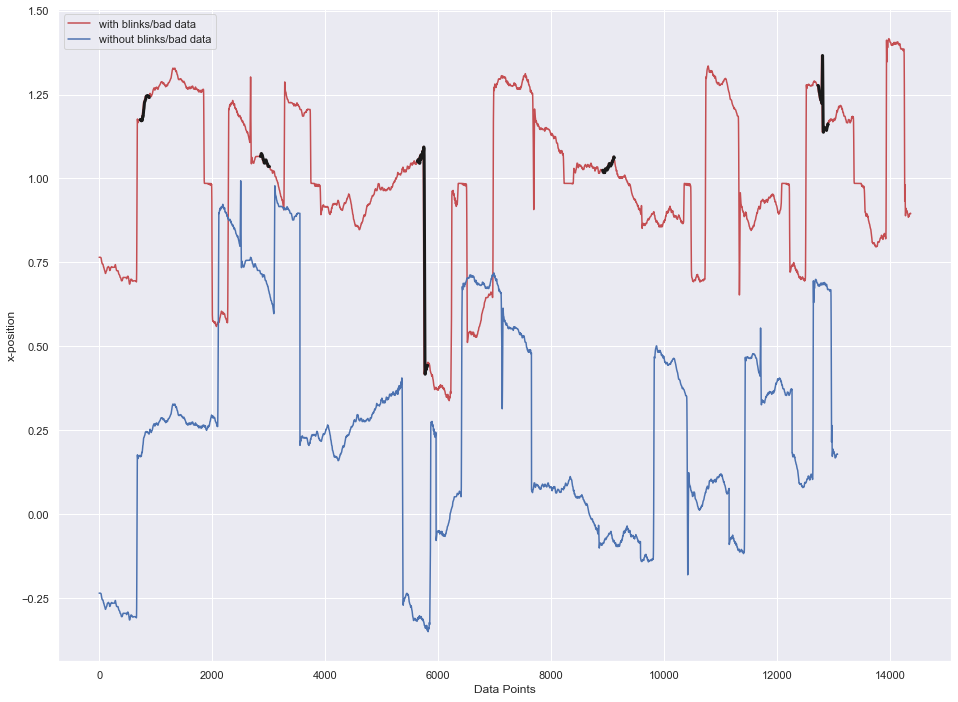

In [8]:
blinkposind = np.where(data_dict['cpatient1v1'][:,2] == 0)[0]
blinkpos = data_dict['cpatient1v1'][blinkposind,0]
plt.plot(data_dict['cpatient1v1'][16:-16,0] + 1, c = 'r', label = 'with blinks/bad data')
ms1 = np.arange(728,891,1)
ms2 = np.arange(2856,3018,1)
ms3 = np.arange(5635,5817,1)
ms4 = np.arange(8913,9120,1)
ms5 = np.arange(12724,12907,1)
plt.plot(ms1, data_dict['cpatient1v1'][728:891,0]+1, c = 'k', linewidth = 3)
plt.plot(ms2, data_dict['cpatient1v1'][2856:3018,0]+1, c = 'k', linewidth = 3)
plt.plot(ms3, data_dict['cpatient1v1'][5635:5817,0]+1, c = 'k', linewidth = 3)
plt.plot(ms4, data_dict['cpatient1v1'][8913:9120,0]+1, c = 'k', linewidth = 3)
plt.plot(ms5, data_dict['cpatient1v1'][12724:12907,0]+1, c = 'k', linewidth = 3)

xx = delete_stitch(data_dict['cpatient1v1'])
plt.plot(xx[:,0], c = 'b', label = 'without blinks/bad data')
plt.xlabel('Data Points')
plt.ylabel('x-position')
plt.legend()
# making plot bigger (might need to run this cell twice to see change in plot size)
plot_size = plt.rcParams["figure.figsize"]
# [0] is width and [1] is height
plot_size[0] = 16
plot_size[1] = 12
#plt.savefig('blinks_noblinks.png', bbox_inches = 'tight')
plt.show()

### **4. Delete blinks and stitch data from all of the files of each patient to create two variables with all their data in them** ###

In [5]:
# delete and stitch individual files
new_data_dict = {}
for i in range(4):
    for j in range(3):
        new_data_dict['cpatient'+str(i+1)+'v'+str(j+1)] = delete_stitch(data_dict['cpatient'+str(i+1)+'v'+str(j+1)])
        new_data_dict['npatient'+str(i+1)+'v'+str(j+1)] = delete_stitch(data_dict['npatient'+str(i+1)+'v'+str(j+1)])
for i in range(3):
    new_data_dict['ctestpatient1v'+str(i+1)] = delete_stitch(data_dict['ctestpatient1v'+str(i+1)])
    new_data_dict['ntestpatient1v'+str(i+1)] = delete_stitch(data_dict['ntestpatient1v'+str(i+1)])

# concatenate all trials from single patient
cpatient, npatient, ctestpatient, ntestpatient = np.array([[0,0,0],[0,0,0]]), np.array([[0,0,0],[0,0,0]]), np.array([[0,0,0],[0,0,0]]), np.array([[0,0,0],[0,0,0]])
both_patient = np.array([[0,0,0],[0,0,0]])
buffer = np.array([[0,0,0],[0,0,0]])
for i in range(4):
    for j in range(3):
        if i<3 and j<2:
            cpatient = np.concatenate((cpatient, new_data_dict['cpatient'+str(i+1)+'v'+str(j+1)]), axis = 0)
            cpatient = np.concatenate((cpatient, buffer), axis = 0)
            npatient = np.concatenate((npatient, new_data_dict['npatient'+str(i+1)+'v'+str(j+1)]), axis = 0)
            npatient = np.concatenate((npatient, buffer), axis = 0)
        if i==3 and j==2:
            cpatient = np.concatenate((cpatient, new_data_dict['cpatient'+str(i+1)+'v'+str(j+1)]), axis = 0)
            npatient = np.concatenate((npatient, new_data_dict['npatient'+str(i+1)+'v'+str(j+1)]), axis = 0)
            
for i in range(3):
    if i <2:
        ctestpatient = np.concatenate((ctestpatient, new_data_dict['ctestpatient1v' + str(i+1)]), axis = 0)
        ctestpatient = np.concatenate((ctestpatient, buffer), axis = 0)
        ntestpatient = np.concatenate((ntestpatient, new_data_dict['ntestpatient1v' + str(i+1)]), axis = 0)
        ntestpatient = np.concatenate((ntestpatient, buffer), axis = 0)
    if i==2:         
        ctestpatient = np.concatenate((ctestpatient, new_data_dict['ctestpatient1v' + str(i+1)]), axis = 0)
        ntestpatient = np.concatenate((ntestpatient, new_data_dict['ntestpatient1v' + str(i+1)]), axis = 0)

cpatient, npatient = np.delete(cpatient, [0,1], 0), np.delete(npatient, [0,1], 0)
cpatient, npatient = delete_stitch(cpatient), delete_stitch(npatient)

ctestpatient, ntestpatient = np.delete(ctestpatient, [0,1], 0), np.delete(ntestpatient, [0,1], 0)
ctestpatient, ntestpatient = delete_stitch(ctestpatient), delete_stitch(ntestpatient)

both_patient = np.concatenate((both_patient, cpatient), axis = 0)
both_patient = np.concatenate((both_patient, buffer), axis = 0)
both_patient = np.concatenate((both_patient, npatient), axis = 0)
both_patient = np.delete(both_patient, [0,1],0)
both_patient = delete_stitch(both_patient)

In [16]:
len(np.where(cpatient[:,2] == 1)[0])

82963

### **5. Create sliding window (nonoverlapping and overlapping) with the patient data** ###

Run "nonoverlapping windows" cell ONLY if you want nonoverlapping windows

In [6]:
#NONOVERLAPPING WINDOWS
window_size = 12
# create matrices needed for 1D CNN
c_xpos, c_ypos, c_vel = all_feature_data(cpatient)
c_xpos_win, c_ypos_win, c_vel_win = nonoverlapping_windows(c_xpos, window_size), nonoverlapping_windows(c_ypos, window_size), nonoverlapping_windows(c_vel, window_size)
c_ms_xpos, c_ms_ypos, c_ms_vel = MS_extraction(c_xpos_win, window_size), MS_extraction(c_ypos_win, window_size), MS_extraction(c_vel_win, window_size)
c_labels = c_ms_xpos[:, -1].astype(int)
c_final_data = stack_features(c_ms_xpos, c_ms_ypos, c_ms_vel)

n_xpos, n_ypos, n_vel = all_feature_data(npatient)
n_xpos_win, n_ypos_win, n_vel_win = nonoverlapping_windows(n_xpos, window_size), nonoverlapping_windows(n_ypos, window_size), nonoverlapping_windows(n_vel, window_size)
n_ms_xpos, n_ms_ypos, n_ms_vel = MS_extraction(n_xpos_win, window_size), MS_extraction(n_ypos_win, window_size), MS_extraction(n_vel_win, window_size)
n_labels = n_ms_xpos[:, -1].astype(int)
n_final_data = stack_features(n_ms_xpos, n_ms_ypos, n_ms_vel)

both_xpos, both_ypos, both_vel = all_feature_data(both_patient)
both_xpos_win, both_ypos_win, both_vel_win = nonoverlapping_windows(both_xpos, window_size), nonoverlapping_windows(both_ypos, window_size), nonoverlapping_windows(both_vel, window_size)
both_ms_xpos, both_ms_ypos, both_ms_vel = MS_extraction(both_xpos_win, window_size), MS_extraction(both_ypos_win, window_size), MS_extraction(both_vel_win, window_size)
both_labels = both_ms_xpos[:, -1].astype(int)
both_final_data = stack_features(both_ms_xpos, both_ms_ypos, both_ms_vel)

ctest_xpos, ctest_ypos, ctest_vel = all_feature_data(ctestpatient)
ctest_xpos_win, ctest_ypos_win, ctest_vel_win = nonoverlapping_windows(ctest_xpos, window_size), nonoverlapping_windows(ctest_ypos, window_size), nonoverlapping_windows(ctest_vel, window_size)
ctest_ms_xpos, ctest_ms_ypos, ctest_ms_vel = MS_extraction(ctest_xpos_win, window_size), MS_extraction(ctest_ypos_win, window_size), MS_extraction(ctest_vel_win, window_size)
ctest_labels = ctest_ms_xpos[:, -1].astype(int)
ctest_final_data = stack_features(ctest_ms_xpos, ctest_ms_ypos, ctest_ms_vel)

ntest_xpos, ntest_ypos, ntest_vel = all_feature_data(ntestpatient)
ntest_xpos_win, ntest_ypos_win, ntest_vel_win = nonoverlapping_windows(ntest_xpos, window_size), nonoverlapping_windows(ntest_ypos, window_size), nonoverlapping_windows(ntest_vel, window_size)
ntest_ms_xpos, ntest_ms_ypos, ntest_ms_vel = MS_extraction(ntest_xpos_win, window_size), MS_extraction(ntest_ypos_win, window_size), MS_extraction(ntest_vel_win, window_size)
ntest_labels = ntest_ms_xpos[:, -1].astype(int)
ntest_final_data = stack_features(ntest_ms_xpos, ntest_ms_ypos, ntest_ms_vel)

Is data already stitched? (0 = no, 1 = yes) 1
Is data already stitched? (0 = no, 1 = yes) 1
Is data already stitched? (0 = no, 1 = yes) 1
Is data already stitched? (0 = no, 1 = yes) 1
Is data already stitched? (0 = no, 1 = yes) 1


Run "overlapping windows" cell ONLY if you want overlapping windows

In [24]:
## OVERLAPPING WINDOWS
window_size = 10
# create matrices needed for 1D CNN
c_xpos, c_ypos, c_vel = all_feature_data(cpatient)
c_xpos_win, c_ypos_win, c_vel_win = overlapping_windows(c_xpos, window_size), overlapping_windows(c_ypos, window_size), overlapping_windows(c_vel, window_size)
c_ms_xpos, c_ms_ypos, c_ms_vel = MS_extraction(c_xpos_win, window_size), MS_extraction(c_ypos_win, window_size), MS_extraction(c_vel_win, window_size)
c_labels = c_ms_xpos[:, -1].astype(int)
c_final_data = stack_features(c_ms_xpos, c_ms_ypos, c_ms_vel)

n_xpos, n_ypos, n_vel = all_feature_data(npatient)
n_xpos_win, n_ypos_win, n_vel_win = overlapping_windows(n_xpos, window_size), overlapping_windows(n_ypos, window_size), overlapping_windows(n_vel, window_size)
n_ms_xpos, n_ms_ypos, n_ms_vel = MS_extraction(n_xpos_win, window_size), MS_extraction(n_ypos_win, window_size), MS_extraction(n_vel_win, window_size)
n_labels = n_ms_xpos[:, -1].astype(int)
n_final_data = stack_features(n_ms_xpos, n_ms_ypos, n_ms_vel)

both_xpos, both_ypos, both_vel = all_feature_data(both_patient)
both_xpos_win, both_ypos_win, both_vel_win = overlapping_windows(both_xpos, window_size), overlapping_windows(both_ypos, window_size), overlapping_windows(both_vel, window_size)
both_ms_xpos, both_ms_ypos, both_ms_vel = MS_extraction(both_xpos_win, window_size), MS_extraction(both_ypos_win, window_size), MS_extraction(both_vel_win, window_size)
both_labels = both_ms_xpos[:, -1].astype(int)
both_final_data = stack_features(both_ms_xpos, both_ms_ypos, both_ms_vel)

ctest_xpos, ctest_ypos, ctest_vel = all_feature_data(ctestpatient)
ctest_xpos_win, ctest_ypos_win, ctest_vel_win = overlapping_windows(ctest_xpos, window_size), overlapping_windows(ctest_ypos, window_size), overlapping_windows(ctest_vel, window_size)
ctest_ms_xpos, ctest_ms_ypos, ctest_ms_vel = MS_extraction(ctest_xpos_win, window_size), MS_extraction(ctest_ypos_win, window_size), MS_extraction(ctest_vel_win, window_size)
ctest_labels = ctest_ms_xpos[:, -1].astype(int)
ctest_final_data = stack_features(ctest_ms_xpos, ctest_ms_ypos, ctest_ms_vel)

ntest_xpos, ntest_ypos, ntest_vel = all_feature_data(ntestpatient)
ntest_xpos_win, ntest_ypos_win, ntest_vel_win = overlapping_windows(ntest_xpos, window_size), overlapping_windows(ntest_ypos, window_size), overlapping_windows(ntest_vel, window_size)
ntest_ms_xpos, ntest_ms_ypos, ntest_ms_vel = MS_extraction(ntest_xpos_win, window_size), MS_extraction(ntest_ypos_win, window_size), MS_extraction(ntest_vel_win, window_size)
ntest_labels = ntest_ms_xpos[:, -1].astype(int)
ntest_final_data = stack_features(ntest_ms_xpos, ntest_ms_ypos, ntest_ms_vel)

Is data already stitched? (0 = no, 1 = yes) 1
Is data already stitched? (0 = no, 1 = yes) 1
Is data already stitched? (0 = no, 1 = yes) 1
Is data already stitched? (0 = no, 1 = yes) 1
Is data already stitched? (0 = no, 1 = yes) 1


### **6. Plot graph of raw data and microsaccade extracted data and show the distribution of drifts and microsaccades in black** ###

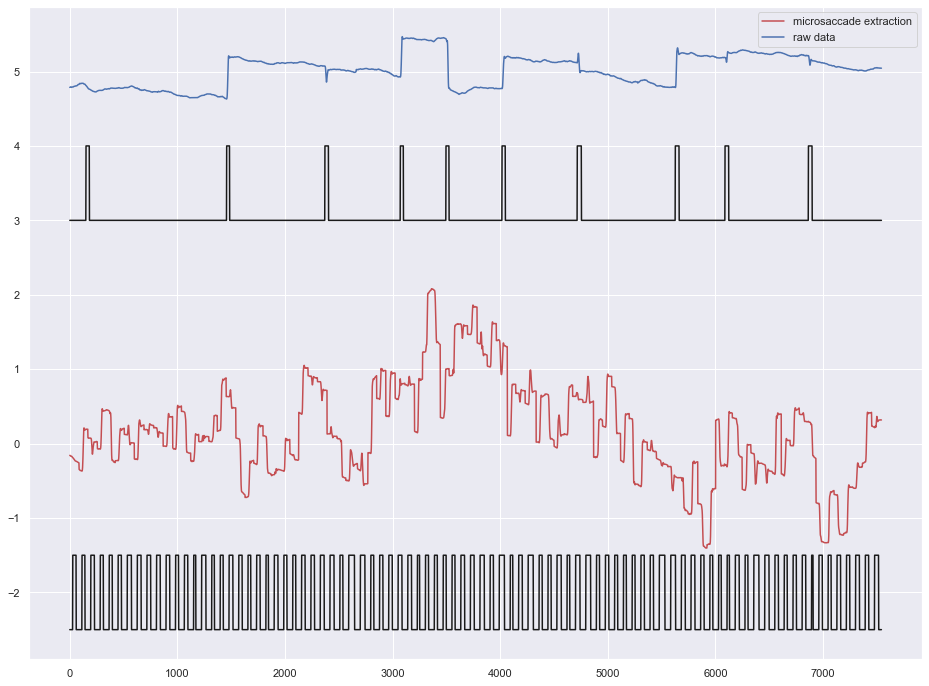

In [10]:
testing = MS_extraction(xpos1.T, 1)
plt.plot(testing[:,0], c = 'r', label = 'microsaccade extraction')
ms_ind1 = np.zeros(testing.shape[0])
for i in range(len(testing)):
    if testing[i,1] == 1:
        ms_ind1[i] = -1.5
    if testing[i,1] == 2:
        ms_ind1[i] = -0.5
plt.plot(ms_ind1 - 1, c = 'k')

plt.plot(xpos1[0, 0:len(testing)] + 5, c = 'b', label = 'raw data')
ms_ind2 = np.zeros(len(xpos1[0,0:len(testing)]))
for i in range(len(xpos1[0,0:len(testing)])):
    if xpos1[1,i] == 1:
        ms_ind2[i] = 3
    if xpos1[1,i] == 2:
        ms_ind2[i] = 4
plt.plot(ms_ind2, c = 'k')
plt.legend()
#plt.savefig('msextraction.png', bbox_inches = 'tight')
plt.show()

### **7. Plot graph with x and y positions with microsaccades shown in green (velocity plotted underneath as well)** ###

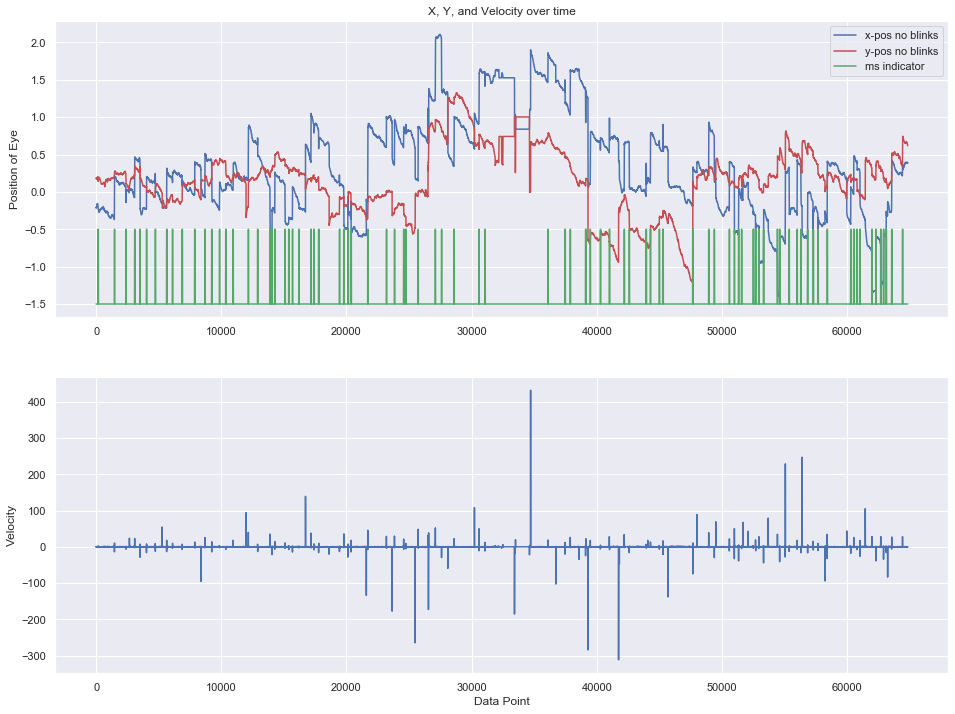

In [11]:
# grab all areas where ms are to plot
ms_idx = np.where(labels1 == 2)[0]
ms_indicator = []
for i in range(xpos1.shape[1]):
    if xpos1[1,i] == 1:
        ms_indicator.append(-1.5)
    if xpos1[1,i] == 2:
        ms_indicator.append(-0.5)

# plot x and y position
plt.subplot(211)
plt.plot(xpos1[0,:], c = 'b', label = 'x-pos no blinks')
plt.plot(ypos1[0,:], c = 'r', label = 'y-pos no blinks')
plt.plot(ms_indicator, c = 'g', label = 'ms indicator')
plt.ylabel('Position of Eye')
plt.title('X, Y, and Velocity over time')
plt.legend()
# plot velocity
plt.subplot(212)
plt.plot(vel1[0,:])
plt.xlabel('Data Point')
plt.ylabel('Velocity')
# making plot bigger (might need to run this cell twice to see change in plot size)
plot_size = plt.rcParams["figure.figsize"]
# [0] is width and [1] is height
plot_size[0] = 16
plot_size[1] = 12
plt.show()

### **8. Run 1D CNN with one or two datasets** ###

1D CNN with one dataset: data from one patient is split into training and testing data (80/20 split)

In [11]:
acc1 = []
for i in range(10):
    print("Trial #{}".format(i+1))
    a,p = one_dataset_CNN(final_data1, labels1)
    acc1.append(a)

Trial #1
Accuracy = 90.775%
Trial #2
Accuracy = 90.903%
Trial #3
Accuracy = 90.903%
Trial #4
Accuracy = 90.711%
Trial #5
Accuracy = 90.647%
Trial #6
Accuracy = 90.967%
Trial #7
Accuracy = 90.391%
Trial #8
Accuracy = 90.775%
Trial #9
Accuracy = 91.095%
Trial #10
Accuracy = 91.031%


1D CNN with two datasets: data from one patient is used to train the model and data from another patient is used to test the model

In [25]:
acc2 = []
for i in range(10):
    print("Trial #{}".format(i+1))
    a, p = two_dataset_CNN(c_final_data, c_labels, ctest_final_data, ctest_labels)
    acc2.append(a)

Trial #1
Accuracy = 90.235%
Trial #2
Accuracy = 89.525%
Trial #3
Accuracy = 89.836%
Trial #4
Accuracy = 90.524%
Trial #5
Accuracy = 90.746%
Trial #6
Accuracy = 90.213%
Trial #7
Accuracy = 89.88%
Trial #8
Accuracy = 90.502%
Trial #9
Accuracy = 90.723%
Trial #10
Accuracy = 90.235%


### **9. Plot window size as a function of accuracy, comparing overlapping and nonoverlapping windows** ###

Run "nonoverlapping windows" cell ONLY if you want nonoverlapping windows

In [10]:
#NONOVERLAPPING WINDOWS
start = time.time()
max_window_size = 16
min_window_size = 4
nonoveracc = np.zeros(max_window_size-min_window_size+1)
for i in range(min_window_size, max_window_size+1):
    print("Window size {}".format(i))
    window_size = i
    
    both_xpos, both_ypos, both_vel = deleted_all_feature_data(both_patient)
    both_xpos_win, both_ypos_win, both_vel_win = nonoverlapping_windows(both_xpos, window_size), nonoverlapping_windows(both_ypos, window_size), nonoverlapping_windows(both_vel, window_size)
    both_ms_xpos, both_ms_ypos, both_ms_vel = MS_extraction(both_xpos_win, window_size), MS_extraction(both_ypos_win, window_size), MS_extraction(both_vel_win, window_size)
    both_labels = both_ms_xpos[:, -1].astype(int)
    both_final_data = stack_features(both_ms_xpos, both_ms_ypos, both_ms_vel)

    ctest_xpos, ctest_ypos, ctest_vel = deleted_all_feature_data(ctestpatient)
    ctest_xpos_win, ctest_ypos_win, ctest_vel_win = nonoverlapping_windows(ctest_xpos, window_size), nonoverlapping_windows(ctest_ypos, window_size), nonoverlapping_windows(ctest_vel, window_size)
    ctest_ms_xpos, ctest_ms_ypos, ctest_ms_vel = MS_extraction(ctest_xpos_win, window_size), MS_extraction(ctest_ypos_win, window_size), MS_extraction(ctest_vel_win, window_size)
    ctest_labels = ctest_ms_xpos[:, -1].astype(int)
    ctest_final_data = stack_features(ctest_ms_xpos, ctest_ms_ypos, ctest_ms_vel)

    accuracy = []
    for j in range(10):
        a, p = two_dataset_CNN(both_final_data, both_labels, ctest_final_data, ctest_labels)
        accuracy.append(a)
        
    mean_acc = np.mean(np.asarray(accuracy))
    nonoveracc[i-min_window_size] = mean_acc
end = time.time()
print("Time elapsed: {} seconds".format(np.round(end-start, 3)))

Window size 4
Accuracy = 87.666%
Accuracy = 87.4%
Accuracy = 87.489%
Accuracy = 87.134%
Accuracy = 87.489%
Accuracy = 87.4%
Accuracy = 87.844%
Accuracy = 87.578%
Accuracy = 87.755%
Accuracy = 87.223%
Window size 5
Accuracy = 85.393%
Accuracy = 87.516%
Accuracy = 86.767%
Accuracy = 86.267%
Accuracy = 86.517%
Accuracy = 87.016%
Accuracy = 86.517%
Accuracy = 85.768%
Accuracy = 86.267%
Accuracy = 86.267%
Window size 6
Accuracy = 88.977%
Accuracy = 89.11%
Accuracy = 88.579%
Accuracy = 88.712%
Accuracy = 88.712%
Accuracy = 88.977%
Accuracy = 89.774%
Accuracy = 89.11%
Accuracy = 88.845%
Accuracy = 88.446%
Window size 7
Accuracy = 89.616%
Accuracy = 88.762%
Accuracy = 88.905%
Accuracy = 88.905%
Accuracy = 89.474%
Accuracy = 89.758%
Accuracy = 89.189%
Accuracy = 89.047%
Accuracy = 89.189%
Accuracy = 88.193%
Window size 8
Accuracy = 89.52%
Accuracy = 89.52%
Accuracy = 90.053%
Accuracy = 88.988%
Accuracy = 89.343%
Accuracy = 88.81%
Accuracy = 89.698%
Accuracy = 89.343%
Accuracy = 89.698%
Accuracy

Run "overlapping windows" cell ONLY if you want overlapping windows

In [11]:
# OVERLAPPING WINDOWS
start = time.time()
max_window_size = 16
min_window_size = 4
overacc = np.zeros(max_window_size-min_window_size+1)
for i in range(min_window_size, max_window_size+1):
    print("Window size {}".format(i))
    window_size = i
    
    both_xpos, both_ypos, both_vel = deleted_all_feature_data(both_patient)
    both_xpos_win, both_ypos_win, both_vel_win = overlapping_windows(both_xpos, window_size), overlapping_windows(both_ypos, window_size), overlapping_windows(both_vel, window_size)
    both_ms_xpos, both_ms_ypos, both_ms_vel = MS_extraction(both_xpos_win, window_size), MS_extraction(both_ypos_win, window_size), MS_extraction(both_vel_win, window_size)
    both_labels = both_ms_xpos[:, -1].astype(int)
    both_final_data = stack_features(both_ms_xpos, both_ms_ypos, both_ms_vel)

    ctest_xpos, ctest_ypos, ctest_vel = deleted_all_feature_data(ctestpatient)
    ctest_xpos_win, ctest_ypos_win, ctest_vel_win = overlapping_windows(ctest_xpos, window_size), overlapping_windows(ctest_ypos, window_size), overlapping_windows(ctest_vel, window_size)
    ctest_ms_xpos, ctest_ms_ypos, ctest_ms_vel = MS_extraction(ctest_xpos_win, window_size), MS_extraction(ctest_ypos_win, window_size), MS_extraction(ctest_vel_win, window_size)
    ctest_labels = ctest_ms_xpos[:, -1].astype(int)
    ctest_final_data = stack_features(ctest_ms_xpos, ctest_ms_ypos, ctest_ms_vel)
    
    accuracy = []
    for j in range(10):
        a, p = two_dataset_CNN(both_final_data, both_labels, ctest_final_data, ctest_labels)
        accuracy.append(a)
        
    mean_acc = np.mean(np.asarray(accuracy))
    overacc[i-min_window_size] = mean_acc
end = time.time()
print("Time elapsed: {} seconds".format(np.round(end-start, 3)))

Window size 4
Accuracy = 88.105%
Accuracy = 88.238%
Accuracy = 88.438%
Accuracy = 88.171%
Accuracy = 88.549%
Accuracy = 88.216%
Accuracy = 88.593%
Accuracy = 88.771%
Accuracy = 88.238%
Accuracy = 88.504%
Window size 5
Accuracy = 88.899%
Accuracy = 88.966%
Accuracy = 88.854%
Accuracy = 88.494%
Accuracy = 89.146%
Accuracy = 88.652%
Accuracy = 88.809%
Accuracy = 88.607%
Accuracy = 88.876%
Accuracy = 88.719%
Window size 6
Accuracy = 89.991%
Accuracy = 89.614%
Accuracy = 89.436%
Accuracy = 89.569%
Accuracy = 89.925%
Accuracy = 88.948%
Accuracy = 89.414%
Accuracy = 89.348%
Accuracy = 90.235%
Accuracy = 90.036%
Window size 7
Accuracy = 90.045%
Accuracy = 90.315%
Accuracy = 90.045%
Accuracy = 90.09%
Accuracy = 89.573%
Accuracy = 89.82%
Accuracy = 89.528%
Accuracy = 89.798%
Accuracy = 89.955%
Accuracy = 89.551%
Window size 8
Accuracy = 90.701%
Accuracy = 90.635%
Accuracy = 91.012%
Accuracy = 90.701%
Accuracy = 90.679%
Accuracy = 91.212%
Accuracy = 90.435%
Accuracy = 90.834%
Accuracy = 90.413%
A

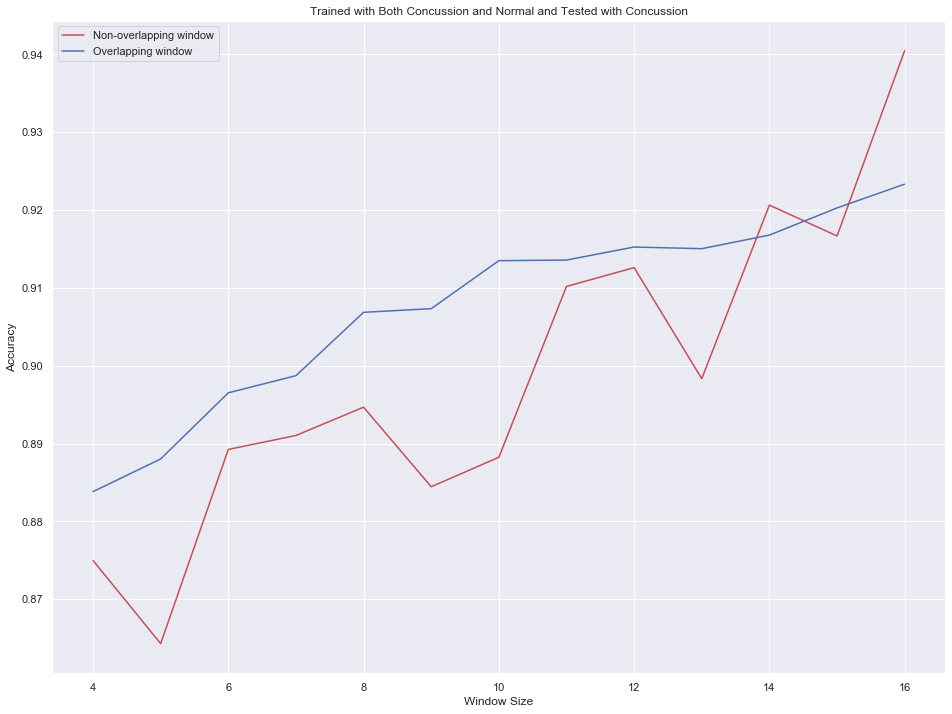

In [13]:
# graph mean accuracy as a function of window size (change file name before running the cell so you don't overwrite )
win = np.array([4,5,6,7,8,9,10,11,12,13,14,15,16])
fig, ax = plt.subplots()
ax.plot(win,nonoveracc,'-',c = 'r',label = 'Non-overlapping window')
ax.plot(win,overacc,'-',c='b',label = 'Overlapping window')
ax.set_xlabel('Window Size')
ax.set_ylabel('Accuracy')
plt.title('Trained with Both Concussion and Normal and Tested with Concussion')
plt.legend()
plot_size = plt.rcParams["figure.figsize"]
plt.rcParams.update({'font.size': 30})
# [0] is width and [1] is height
plot_size[0] = 16
plot_size[1] = 12
plt.show()
#fig.savefig('slidwin_acc_trainboth_testconcuss.png', bbox_inches = 'tight')

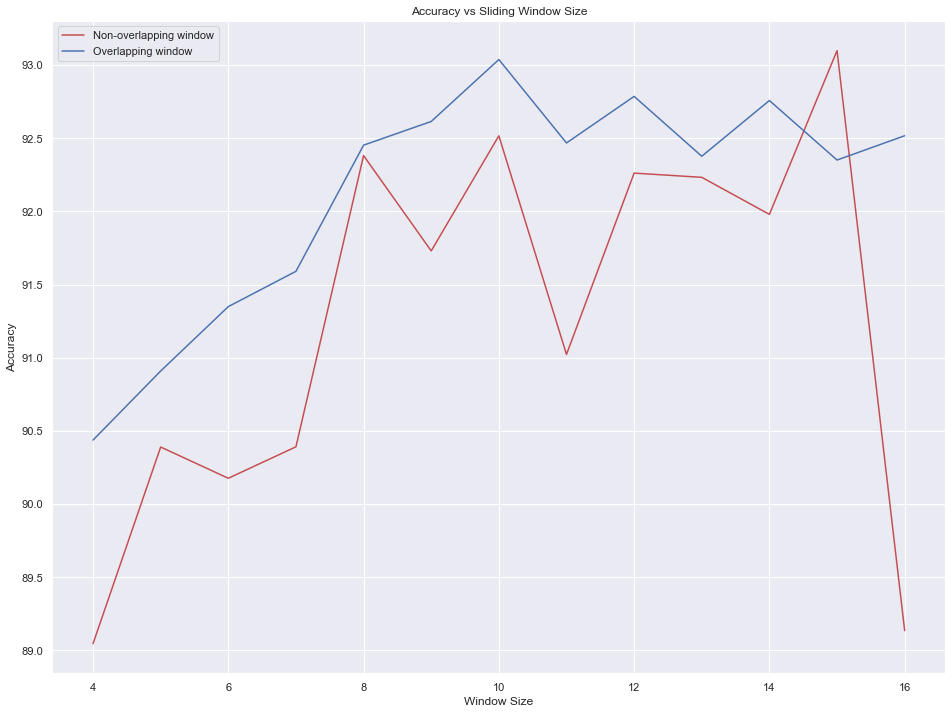

In [9]:
nonoveracc_arr = np.array([89.0467, 90.3903, 90.1768, 90.3918, 92.3817, 91.7304, 92.517, 91.0231, 92.262, 92.2333, 91.9801, 93.099, 89.136])
overacc_arr = np.array([90.4377, 90.9097, 91.3498, 91.5909, 92.453, 92.6149, 93.0382, 92.4681, 92.7863, 92.3773, 92.7581, 92.3514, 92.5173])

win = np.array([4,5,6,7,8,9,10,11,12,13,14,15,16])
fig, ax = plt.subplots()
ax.plot(win,nonoveracc_arr,'-',c = 'r',label = 'Non-overlapping window')
ax.plot(win,overacc_arr,'-',c='b',label = 'Overlapping window')
ax.set_xlabel('Window Size')
ax.set_ylabel('Accuracy')
plt.title('Accuracy vs Sliding Window Size')
plt.legend()
plot_size = plt.rcParams["figure.figsize"]
plt.rcParams.update({'font.size': 30})
# [0] is width and [1] is height
plot_size[0] = 16
plot_size[1] = 12
plt.show()
#fig.savefig('slidwin_acc2.png', bbox_inches = 'tight')

In [47]:
# calculate mean accuracy over ten trials
mean_acc = np.mean(np.asarray(accuracy))

# window sizes: 4,5,6,7,8,9,10,11,12,13,14,15,16
nonover_win_acc = np.array([ 0.9004889, 0.9032350215880106, 0.911167500727964, 0.9103710793348634, 0.9231622478526706, 0.9184966760459794, 0.9208121808114458,
                           0.9200951453507458,0.9288964065500929,0.9171646047387091,0.9175972927667789,0.9188011403485324,0.9005640064186341])
over_win_acc = np.array([ 0.9033840950740238, 0.908981923054333, 0.9138371993520918, 0.9144053287839572,0.9263207395602537,0.9258230193357713,0.9279751800318639,
                         0.9267554647915711,0.9286144029580912,0.9259371973014128,0.9263395388136683,0.924224549514923,0.9243090782225591])

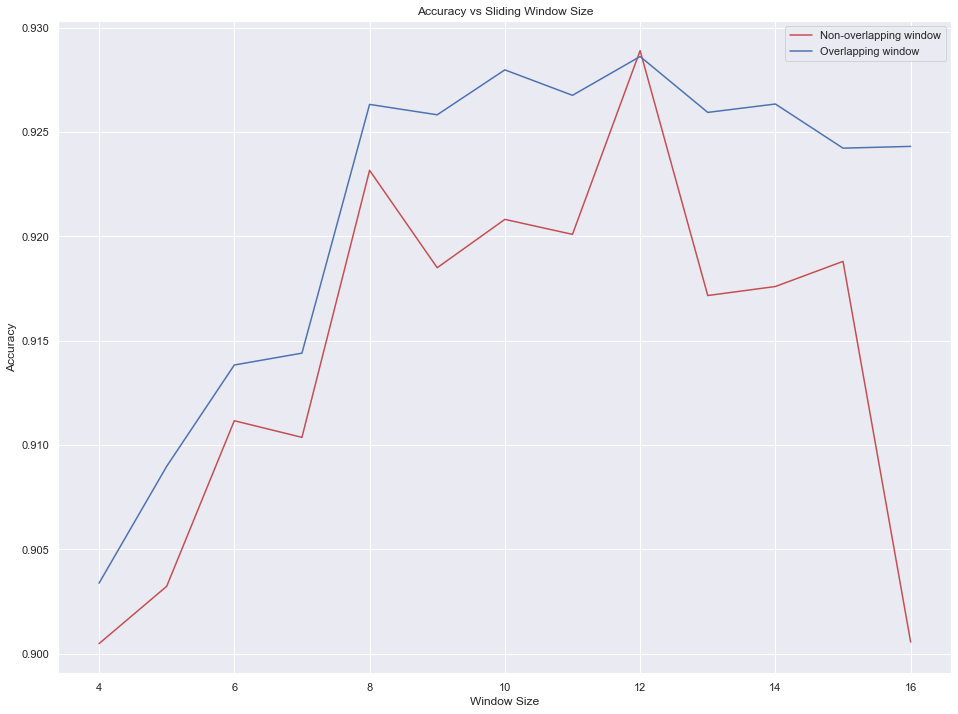

In [54]:
win = np.array([4,5,6,7,8,9,10,11,12,13,14,15,16])
fig, ax = plt.subplots()
ax.plot(win,nonover_win_acc,'-',c = 'r',label = 'Non-overlapping window')
ax.plot(win,over_win_acc,'-',c='b',label = 'Overlapping window')
ax.set_xlabel('Window Size')
ax.set_ylabel('Accuracy')
plt.title('Accuracy vs Sliding Window Size')
plt.legend()
plot_size = plt.rcParams["figure.figsize"]
plt.rcParams.update({'font.size': 30})
# [0] is width and [1] is height
plot_size[0] = 16
plot_size[1] = 12
plt.show()
fig.savefig('slidwin_acc1.png', bbox_inches = 'tight')

In [33]:
def two_dataset_CNN_varfilter(trainX, trainy, testX, testy, n_filters):
    trainy = to_categorical(trainy)
    verbose, epochs, batch_size = 0, 100, 5000
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters = n_filters, kernel_size = 2, activation = 'relu', input_shape = (n_timesteps, n_features)))
    model.add(Conv1D(filters = n_filters, kernel_size = 2, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(n_outputs, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, to_categorical(testy), batch_size = batch_size, verbose = 0)
    predict = model.predict(testX)
    print("Accuracy = {}%".format(np.round(accuracy * 100, 3)))
    return (accuracy, np.rint(predict))

def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    plt.boxplot(scores)
    plt.savefig('exp_cnn_filters.png')
    
# run an experiment
def run_experiment(params, repeats=10):
    # load data
    trainX, trainy, testX, testy = final_data1, labels1, final_data2, labels2
    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score,_ = two_dataset_CNN_varfilter(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)
    
# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
#run_experiment(n_params)

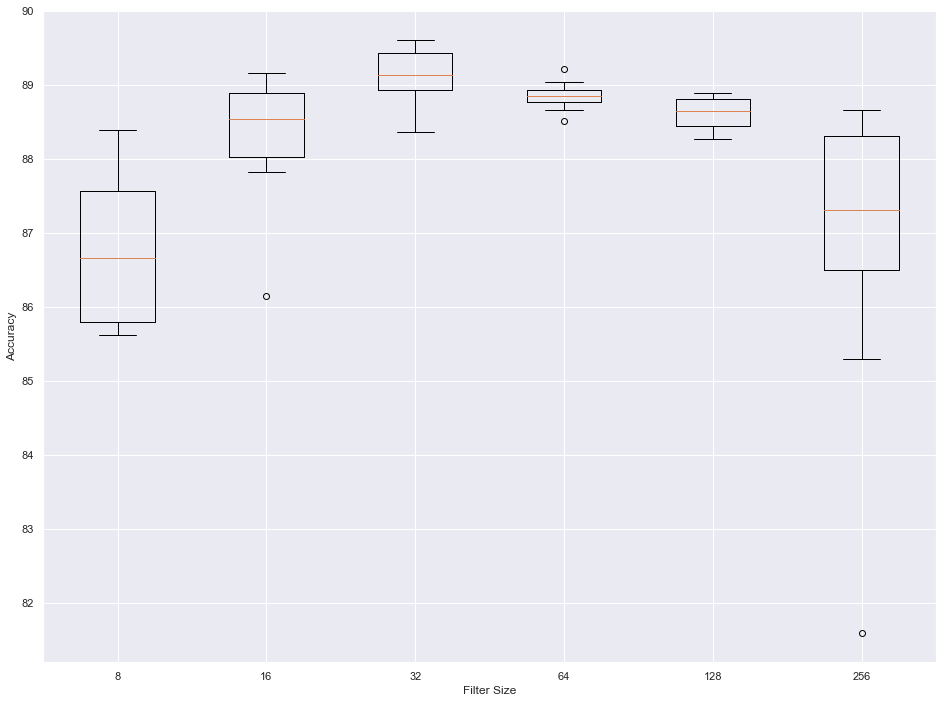

In [41]:
for8 = np.array([87.71300323875496, 86.18834251245575, 86.83408047051707, 87.58744324803887, 85.6143474311572, 85.65022656735817, 87.5156972440369, 88.3946171790495, 85.66815984088744, 86.49327113489399])
for16 = np.array([88.12556328260311, 88.89685965439665, 88.48430337927266, 89.16591731956721, 86.15246746572144, 88.60986336998874, 87.82062680197403, 88.9686081708814, 88.00000045866176, 88.86098869712899])
for32 = np.array([89.04035952059142, 89.0044869863399, 88.91479576115117, 89.6143498976669, 88.3587418115727, 89.30941592952061, 89.56054093591835, 89.47085254395489, 88.89686091063803, 89.21972940855497])
for64 = np.array([88.77129934293806, 88.77130059917945, 88.86098554316123, 88.89685965439665, 89.04035984133391, 88.66367703596039, 89.21973098553883, 88.95067364111074, 88.84304724466641, 88.52017842600698])
for128 = np.array([88.34080728180206, 88.80717564591379, 88.80717596665626, 88.46636852875953, 88.60986713871293, 88.87892322689963, 88.89685933365415, 88.2690597008162, 88.6995520826947, 88.44843210126253])
for256 = np.array([88.28699297434545, 86.34977661440725, 86.94170654621894, 88.66367703596039, 88.46636695177565, 88.32286834182226, 87.01345035848061, 85.29148238122197, 87.60538218801867, 81.59641262661715])
total = [for8, for16, for32, for64, for128, for256]
param = [8,16,32,64,128,256]
xx = np.arange(1,11,1)
#plt.plot(xx, for8, label = 'filter size 8')
#plt.plot(xx, for16, label = 'filter size 16')
#plt.plot(xx, for32, label = 'filter size 32')
#plt.plot(xx, for64, label = 'filter size 64')
#plt.plot(xx, for128, label = 'filter size 128')
#plt.plot(xx, for256, label = 'filter size 256')
plt.boxplot(total, labels = param)
plt.xlabel('Filter Size')
plt.ylabel('Accuracy')
plt.savefig('flter_acc.png', bbox_inches = 'tight')
plt.show()

## **WORK WITH FULL DATASET** ##

In [42]:
# import data
def import_data():
    #------------------- acquire file names from data -------------------#
    centerclearfiles = glob.glob('eyeposwithlabel_PCenterClearanceSacMark/*.csv')
    centerconcussionfiles = glob.glob('eyeposwithlabel_PCenterConcussionSacMark/*.csv')
    centercontrolfiles = glob.glob('eyeposwithlabel_PCenterControlSacMark/*.csv')
    cornerclearfiles = glob.glob('eyeposwithlabel_PCornerClearanceSacMark/*.csv')
    cornerconcussionfiles = glob.glob('eyeposwithlabel_PCornerConcussionSacMark/*.csv')
    cornercontrolfiles = glob.glob('eyeposwithlabel_PCornerControlSacMark/*.csv')
    
    #------------------- create an ID for each data -------------------#
    centerclearID=[]
    for filename in glob.iglob('eyeposwithlabel_PCenterClearanceSacMark/*.csv'):
        centerclearID.append(filename[filename.find('eyeposwithlabel_PCenterClearanceSacMark\\')+40:filename.find('eyeposwithlabel_PCenterClearanceSacMark\\')+54])    
    centerconcussionID=[]
    for filename in glob.iglob('eyeposwithlabel_PCenterConcussionSacMark/*.csv'):
        centerconcussionID.append(filename[filename.find('eyeposwithlabel_PCenterConcussionSacMark\\')+41:filename.find('eyeposwithlabel_PCenterConcussionSacMark\\')+55])
    centercontrolID=[]
    for filename in glob.iglob('eyeposwithlabel_PCenterControlSacMark/*.csv'):
        centercontrolID.append(filename[filename.find('eyeposwithlabel_PCenterControlSacMark\\')+38:filename.find('eyeposwithlabel_PCenterControlSacMark\\')+52])        
    cornerclearID=[]
    for filename in glob.iglob('eyeposwithlabel_PCornerClearanceSacMark/*.csv'):
        cornerclearID.append(filename[filename.find('eyeposwithlabel_PCornerClearanceSacMark\\')+40:filename.find('eyeposwithlabel_PCornerClearanceSacMark\\')+54])      
    cornerconconssionID=[]
    for filename in glob.iglob('eyeposwithlabel_PCornerConcussionSacMark/*.csv'):
        cornerconconssionID.append(filename[filename.find('eyeposwithlabel_PCornerConcussionSacMark\\')+41:filename.find('eyeposwithlabel_PCornerConcussionSacMark\\')+55])
    cornercontrolID=[]
    for filename in glob.iglob('eyeposwithlabel_PCornerControlSacMark/*.csv'):
        cornercontrolID.append(filename[filename.find('eyeposwithlabel_PCornerControlSacMark\\')+38:filename.find('eyeposwithlabel_PCornerControlSacMark\\')+52])
    
    #------------------- convert csv data into pandas dataframe and array -------------------#
    # PCenterClearanceSacMark
    dat = []
    for filename in centerclearfiles:
        df = pd.read_csv(filename, index_col=None, header=0)
        dat.append(df)
    res1 = pd.concat(dat, axis=0, ignore_index=True)
    res1 = res1.to_numpy()
    # PCenterConcussionSacMark
    dat = []
    for filename in centerconcussionfiles:
        df = pd.read_csv(filename, index_col=None, header=0)
        dat.append(df)
    res2 = pd.concat(dat, axis=0, ignore_index=True)
    res2 = res2.to_numpy()
    # PCenterControlSacMark
    dat = []
    for filename in centercontrolfiles:
        df = pd.read_csv(filename, index_col=None, header=0)
        dat.append(df)
    res3 = pd.concat(dat, axis=0, ignore_index=True)
    res3 = res3.to_numpy()
    # PCornerClearanceSacMark
    dat = []
    for filename in cornerclearfiles:
        df = pd.read_csv(filename, index_col=None, header=0)
        dat.append(df)
    res4 = pd.concat(dat, axis=0, ignore_index=True)
    res4 = res4.to_numpy()
    # PCornerConcussionSacMark
    dat = []
    for filename in cornerconcussionfiles:
        df = pd.read_csv(filename, index_col=None, header=0)
        dat.append(df)
    res5 = pd.concat(dat, axis=0, ignore_index=True)
    res5 = res5.to_numpy()
    # PCornerControlSacMark
    dat = []
    for filename in cornercontrolfiles:
        df = pd.read_csv(filename, index_col=None, header=0)
        dat.append(df)
    res6 = pd.concat(dat, axis=0, ignore_index=True)
    res6 = res6.to_numpy()
    
    return(res1,res2,res3,res4,res5,res6)

In [43]:
pos1,pos2,pos3,pos4,pos5,pos6 = import_data()

In [44]:
abspos1 = np.sqrt(pos1[:,0]**2 + pos1[:,1]**2)
abspos2 = np.sqrt(pos2[:,0]**2 + pos2[:,1]**2)
abspos3 = np.sqrt(pos3[:,0]**2 + pos3[:,1]**2)
abspos4 = np.sqrt(pos4[:,0]**2 + pos4[:,1]**2)
abspos5 = np.sqrt(pos5[:,0]**2 + pos5[:,1]**2)
abspos6 = np.sqrt(pos6[:,0]**2 + pos6[:,1]**2)

In [45]:
timediff = 0.0021
vel1 = np.zeros((pos1.shape[0],1))
for i in range(pos1.shape[0]-1):
    vel1[i+1] = (pos1[i,0]-pos1[i,1]/timediff)

In [53]:
size_window = 4
bxpos1, bypos1, bvel1 = all_feature_data(pos1)
bxpos_win1,bypos_win1,bvel_win1 = nonoverlapping_windows(bxpos1, size_window),nonoverlapping_windows(bypos1, size_window),nonoverlapping_windows(bvel1, size_window)
bms_xpos1, bms_ypos1, bms_vel1 = MS_extraction(bxpos_win1, window_size), MS_extraction(bypos_win1, window_size), MS_extraction(bvel_win1, window_size)
blabels1 = bvel_win1[:, -1].astype(int)
final_data1 = stack_features(bms_xpos1, bms_ypos1, bms_vel1)

bxpos2, bypos2, bvel2 = all_feature_data(pos2)
bxpos_win2,bypos_win2,bvel_win2 = nonoverlapping_windows(bxpos2, size_window),nonoverlapping_windows(bypos2, size_window),nonoverlapping_windows(bvel2, size_window)
blabels2 = bxpos_win2[:, -1].astype(int)
bfinal_data2 = stack_features(bxpos_win2, bypos_win2, bvel_win2)

In [51]:
one_dataset_CNN(bfinal_data1, blabels1)

Accuracy = 97.258%


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [60]:
start = time.time()
a,b = two_dataset_CNN(bfinal_data1, blabels1, bfinal_data2, labels2)
end = time.time()
elapsed = end-start
print(elapsed)

ValueError: Input arrays should have the same number of samples as target arrays. Found 645068 input samples and 13087 target samples.